In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from scipy import interp
from sklearn import datasets, neighbors
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline

In [3]:
LW = 2
RANDOM_STATE = 42

In [4]:
# A dummy sampler that returns the original X,y.
class DummySampler(object):
    def sample(self, X, y):
        return X, y
    def fit(self, X, y):
        return self
    def fit_sample(self, X, y):
        return self.sample(X, y)

In [5]:
# Read the data matrix and data labels
X_fname = 'X.binary'
y_fname = 'y.binary'
X = np.loadtxt(open(X_fname, "rb"), dtype=float, delimiter='\t')
y = np.loadtxt(open(y_fname, "rb"), dtype=int, delimiter='\t')
class_names = np.unique(y)

print "X ", X.shape
print "y ", y.shape
print "class_names ", class_names

X  (643, 500)
y  (643,)
class_names  [0 1]


In [6]:
# Create the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y,
        test_size=0.33, random_state=RANDOM_STATE)

print "X_train ", X_train.shape
print "y_train ", y_train.shape

X_train  (430, 500)
y_train  (430,)


In [7]:
# Classifier implementing the k-nearest neighbors vote
classifier = ['3NN', neighbors.KNeighborsClassifier(3)]

# Cross validation
cv = StratifiedKFold(n_splits=3)

# Create a list of undersamplers (name, object)
samplers = [
    ['Standard', DummySampler()],
    ['RUS', RandomUnderSampler(random_state=RANDOM_STATE)],
    ['NEARMISS', NearMiss(version=2)],
    ['TOMEKLINK', TomekLinks()]]

# Create a list of pipelines (name, object)
pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
      make_pipeline(sampler[1], classifier[1])
    ] for sampler in samplers
]

In [8]:
# Run each pipeline and plot the AUC
for name, pipeline in pipelines:
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        probas_ = pipeline.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, linestyle='--',
             label='{} (area = %0.2f)'.format(name) % mean_auc, lw=LW)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic, Undersampling with '
            + str(X.shape[1])
            + ' features')
    plt.legend(loc="lower right")

In [9]:
# Plot the AUC for a random guess
plt.plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k', label='Luck')

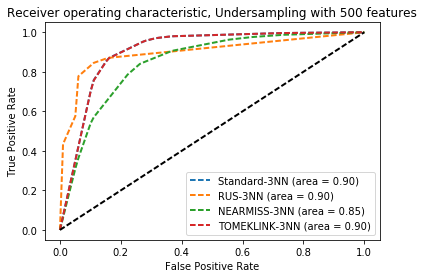

In [10]:
plt.show()